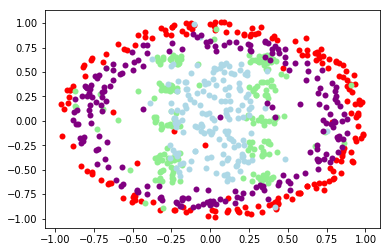

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_moons
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn import datasets
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
import pandas as pd
import numpy as np
import csv

direction ="C:/Users/gary1345aa/Documents/GitHub/ml/labs/08_CV_Ensembling/CV_playground_dataset/"

file = open(direction + 'train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X = np.vstack((X, np.array(row[0:2])))
  y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)
plt.show()

In [12]:
# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
# hold out validation set
X_itrain, X_val, y_itrain, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)

In [13]:
best_k, best_score = -1, -1
clfs = {}

# hyperparameter tuning
for k in [1, 15, 50]:
  pipe = Pipeline([['sc', StandardScaler()],
                   ['clf', KNeighborsClassifier(n_neighbors=k)]])
  pipe.fit(X_itrain, y_itrain)
  y_pred = pipe.predict(X_val)
  score = accuracy_score(y_val, y_pred)
  print('[{}-NN]\nValidation accuracy: {}'.format(k, score))
  if score > best_score:
    best_k, best_score = k, score
  clfs[k] = pipe

clf = clfs[best_k]
clf.fit(X_train, y_train)
# performance reporting
y_pred = clf.predict(X_test)
print('\nTest accuracy: %.2f (n_neighbors=%d selected by the holdout method)' %
      (accuracy_score(y_test, y_pred), best_k))

[1-NN]
Validation accuracy: 0.8064516129032258
[15-NN]
Validation accuracy: 0.6967741935483871
[50-NN]
Validation accuracy: 0.6193548387096774

Test accuracy: 0.77 (n_neighbors=1 selected by the holdout method)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

best_k, best_score = -1, -1
clfs = {}

for k in [1, 15, 50]:  # experiment different hyperparameter
  pipe = Pipeline([['sc', StandardScaler()],
                   ['clf', KNeighborsClassifier(n_neighbors=k)]])
  pipe.fit(X_train, y_train)
  # K-Fold CV
  scores = cross_val_score(pipe, X_train, y_train, cv=5)
  print('[%d-NN]\nValidation accuracy: %.3f %s' % (k, scores.mean(), scores))
  if scores.mean() > best_score:
    best_k, best_score = k, scores.mean()
  clfs[k] = pipe

best_clf = clfs[best_k]
best_clf.fit(X_train, y_train)

# performance reporting
y_pred = best_clf.predict(X_test)
print('\nTest accuracy: %.2f (n_neighbors=%d selected by 5-fold CV)' %
      (accuracy_score(y_test, y_pred), best_k))

[1-NN]
Validation accuracy: 0.781 [ 0.79047619  0.77884615  0.78640777  0.77669903  0.77227723]
[15-NN]
Validation accuracy: 0.727 [ 0.71428571  0.70192308  0.70873786  0.7961165   0.71287129]
[50-NN]
Validation accuracy: 0.624 [ 0.6         0.64423077  0.60194175  0.66019417  0.61386139]

Test accuracy: 0.83 (n_neighbors=1 selected by 5-fold CV)


In [18]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
  print('[Outer fold %d/5]' % (i + 1))
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  best_k, best_score = -1, -1
  clfs = {}
  # hyperparameter tuning
  for k in [1, 15, 50]:
    inner_scores = []
    # inner folds
    for itrain_idx, val_idx in inner_cv.split(X_train, y_train):
      X_itrain, X_val = X_train[itrain_idx], X_train[val_idx]
      y_itrain, y_val = y_train[itrain_idx], y_train[val_idx]

      pipe = Pipeline([['sc', StandardScaler()],
                       ['clf', KNeighborsClassifier(n_neighbors=k)]])
      pipe.fit(X_itrain, y_itrain)

      y_pred = pipe.predict(X_val)
      inner_scores.append(accuracy_score(y_val, y_pred))
    score_mean = np.mean(inner_scores)
    if best_score < score_mean:
      best_k, best_score = k, score_mean
    clfs[k] = pipe

  # evaluate performance on test fold
  best_clf = clfs[best_k]
  best_clf.fit(X_train, y_train)
  y_pred = best_clf.predict(X_test)
  outer_scores.append(accuracy_score(y_test, y_pred))
  print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' %
        (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x2 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.82 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.81 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.78 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.77 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.82 (n_neighbors=1 selected by inner 10-fold CV)

Test accuracy: 0.80 (5x2 nested CV)


In [19]:
from sklearn.model_selection import GridSearchCV

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
  print('[Outer fold %d/5]' % (i + 1))
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
  # hyperparameter tuning by grid search CV
  param_grid = {'clf__n_neighbors': [1, 15, 50]}
  gs = GridSearchCV(
      estimator=pipe, param_grid=param_grid, scoring='accuracy', cv=inner_cv)
  gs.fit(X_train, y_train)
  best_clf = gs.best_estimator_
  best_clf.fit(X_train, y_train)
  outer_scores.append(best_clf.score(X_test, y_test))
  print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' %
        (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.82 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.81 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.78 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.77 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.82 (n_neighbors=1 selected by inner 10-fold CV)

Test accuracy: 0.80 (5x10 nested CV)


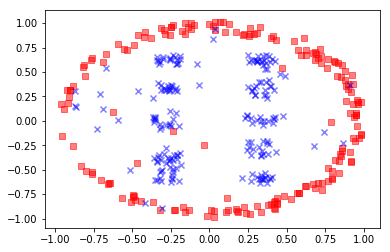

In [20]:
plt.scatter(
    X[y == 0, 0], X[y == 0, 1], label='Class 0', c='r', marker='s', alpha=0.5)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Class 1', c='b', marker='x', alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1], c='', marker='o', label='Class 1')
plt.show()

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', LogisticRegression(C=10, random_state=0)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth=3, random_state=0)]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', KNeighborsClassifier(n_neighbors=5)]])

In [35]:
from sklearn.model_selection import cross_val_score

clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
  scores = cross_val_score(
      estimator=pipe, X=X_train, y=y_train, cv=10)
  print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.283 (+/- 0.040)
DecisionTree: 0.504 (+/- 0.041)
KNN: 0.811 (+/- 0.050)


array([ 3.,  0.,  0.,  3.,  0.,  1.,  1.,  3.,  3.,  3.,  3.,  1.,  2.,
        0.,  3.,  0.,  0.,  2.,  1.,  1.,  1.,  2.,  2.,  2.,  1.,  0.,
        2.,  1.,  0.,  3.,  1.,  2.,  1.,  0.,  3.,  1.,  2.,  0.,  3.,
        2.,  3.,  3.,  1.,  3.,  1.,  2.,  3.,  2.,  3.,  3.,  1.,  1.,
        0.,  1.,  0.,  3.,  2.,  0.,  2.,  2.,  1.,  3.,  1.,  3.,  3.,
        1.,  2.,  3.,  1.,  0.,  1.,  2.,  3.,  2.,  1.,  0.,  1.,  2.,
        3.,  1.,  1.,  2.,  3.,  3.,  1.,  1.,  2.,  2.,  3.,  3.,  3.,
        0.,  2.,  0.,  0.,  0.,  3.,  2.,  1.,  2.,  2.,  1.,  1.,  3.,
        2.,  0.,  3.,  1.,  1.,  1.,  1.,  3.,  2.,  3.,  1.,  0.,  2.,
        3.,  3.,  1.,  3.,  0.,  2.,  1.,  1.,  0.,  3.,  1.,  3.,  2.,
        0.,  3.,  3.,  0.,  2.,  0.,  1.,  1.,  2.,  2.,  3.,  2.,  0.,
        2.,  2.,  0.,  0.])

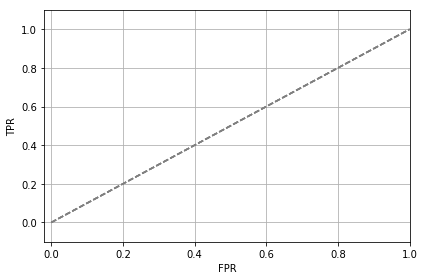

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN', 'Voting']
colors = ['black', 'orange', 'blue', 'green']
linestyles = ['-', '-', '-', '--']
for clf, label, clr, ls in zip([pipe1, pipe2, pipe3, best_vt], clf_labels,
                               colors, linestyles):
  # assume positive class is at dimension 2
  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]

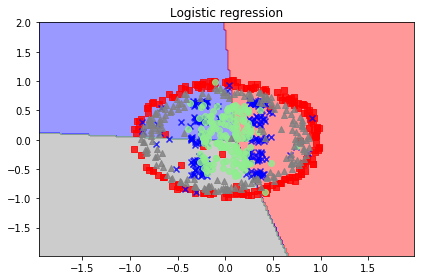

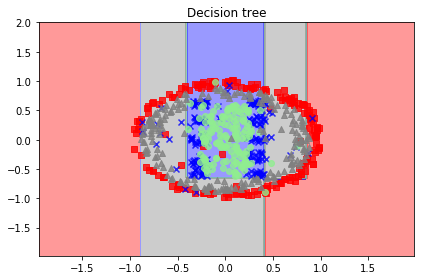

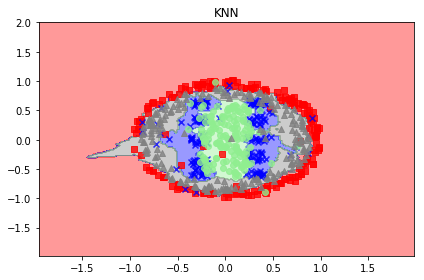

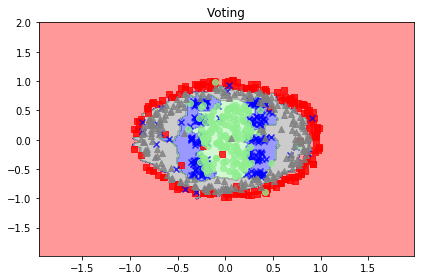

In [38]:
from matplotlib.colors import ListedColormap
def versiontuple(v):
    return tuple(map(int, (v.split("."))))
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=pipe1,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('Logistic regression')
plt.tight_layout()
plt.savefig('./output/fig-vote-logistic-regressio-boundary.png', dpi=300)
plt.show()

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=pipe2,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-vote-decision-tree-boundary.png', dpi=300)
plt.show()

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=pipe3,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('KNN')
plt.tight_layout()
plt.savefig('./output/fig-voting-knn-boundary.png', dpi=300)
plt.show()

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=best_vt,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.savefig('./output/fig-voting-boundary.png', dpi=300)
plt.show()

In [39]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(
    criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(
    base_estimator=tree,
    n_estimators=500,
    max_samples=0.7,
    bootstrap=True,
    max_features=1.0,
    bootstrap_features=False,
    n_jobs=1,
    random_state=1)

In [40]:
from sklearn.metrics import accuracy_score

# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' %
      (tree_train, tree_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('[Bagging] auc-train = %.3f, auc-test = %.3f' % (bag_train, bag_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.762
[Bagging] auc-train = 0.993, auc-test = 0.823


In [41]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' %
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % (ada_train,
                                                                  ada_test))

[DecisionTree] accuracy-train = 0.379, accuracy-test = 0.327
[AdaBoost] accuracy-train = 0.594, accuracy-test = 0.544


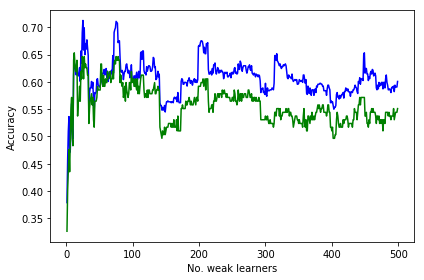

In [42]:
range_est = range(1, 500)
ada_train, ada_test = [], []
for i in range_est:
  ada = AdaBoostClassifier(
      base_estimator=tree, n_estimators=i, learning_rate=1, random_state=1)
  ada = ada.fit(X_train, y_train)
  y_train_pred = ada.predict(X_train)
  y_test_pred = ada.predict(X_test)

  ada_train.append(accuracy_score(y_train, y_train_pred))
  ada_test.append(accuracy_score(y_test, y_test_pred))

plt.plot(range_est, ada_train, color='blue')
plt.plot(range_est, ada_test, color='green')
plt.xlabel('No. weak learners')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-acc.png', dpi=300)
plt.show()